<a href="https://colab.research.google.com/github/sachinmotwani20/SP_Python/blob/master/Ch8%2CSmotthing%26Convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Smoothing & Convolution

Moving Average is used to smoothen a  'noisy' time series data (signal).

*   Moving Average: a succession of averages derived from successive segments (typically of constant size and overlapping) of a series of values

Eg, For a data of 1500 days, instead of taking each day into consideration, we avg 30 days at one point, put it on the 30th location (rest 29 remaining empty) , then shift it one sample right & then the next 30 days, the next point & so on. this smoothens the curve.

*   Moving Average is the ***convolution*** of a signal & a window.


In [0]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

--2020-03-30 20:58:58--  https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkdsp.py [following]
--2020-03-30 20:58:58--  https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkdsp.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47674 (47K) [text/plain]
Saving to: ‘thinkdsp.py’

thinkdsp.py         100%[===================>]  46.56K  --.-KB/s    in 0.01s   

2020-03-30 20:58:58 (3.21 MB/s) - ‘thinkdsp.py’ saved [47674/47674]



In [0]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

In [0]:
#suppress scientific notation for small numbers
np.set_printoptions(precision=3, suppress= True)

#Smoothing 
As the first example, I'll look at [daily closing stock prices for Facebook,](https://finance.yahoo.com/quote/FB/history?period1=1337472000&period2=1585526400&interval=1d&filter=history&frequency=1d) from its IPO on 2012-05-20 to 2020-03-30
 (note: the dataset includes only trading days )

In [0]:
if not os.path.exists('FB.csv'):
    !wget https://github.com/sachinmotwani20/SP_Python/blob/master/Allen%20Downey/Data%20Files%20(Used%20in%20codes)/FB.csv

In [0]:
import pandas as pd

df = pd.read_csv('FB.csv', header = 0, parse_dates=[0])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
1,2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
2,2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
3,2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200
4,2012-05-25,32.900002,32.950001,31.110001,31.910000,31.910000,37149800


In [0]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1971,2020-03-23,149.660004,152.309998,142.250000,148.100006,148.100006,29830800
1972,2020-03-24,155.210007,161.309998,152.570007,160.979996,160.979996,30440400
1973,2020-03-25,158.919998,162.990005,153.059998,156.210007,156.210007,35184300
1974,2020-03-26,158.250000,164.000000,157.020004,163.339996,163.339996,26556800
1975,2020-03-27,158.199997,160.089996,154.750000,156.789993,156.789993,24861900


Extract the close price & days since start of the series:

In [0]:
close = df['Close']
dates = df['Date']
days = (dates - dates [0])/ np.timedelta64(1,'D')

Make a window to compute a 30-days moving average & convolve the window with the data. The 'valid' flag means the convolution is only computed where the window completely overlaps with the signal. 

In [0]:
M=30
window = np.ones(M)
window /= sum(window)
smoothed = np.convolve(close, window, mode ='valid')
smoothed_days =days[M//2: len(smoothed)+ M//2]

Plot the orginal & smoothed signals.

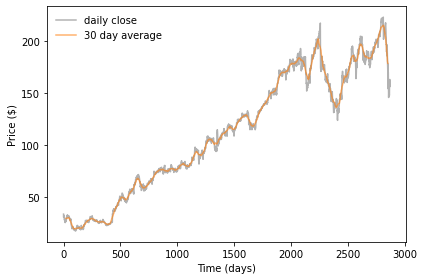

In [0]:
plt.plot(days, close, color='gray', alpha=0.6, label='daily close')
plt.plot(smoothed_days, smoothed, color='C1', alpha=0.6, label='30 day average')

decorate(xlabel='Time (days)', ylabel='Price ($)')

Observe the smoothness of the red corve over the blue curve.

#Smoothing Sound Signals
Generate a 440hz sawtooth signal.

In [0]:
from thinkdsp import SawtoothSignal

signal = SawtoothSignal(freq = 440)
wave = signal.make_wave(duration=1.0, framerate = 44100)
wave.make_audio()

Make a Moving Average Window

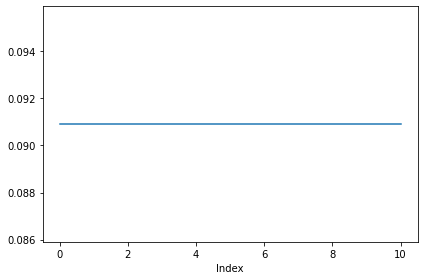

In [0]:
window = np.ones(11)
window /= sum(window)
plt.plot(window)
decorate (xlabel = 'Index')

Plot the wave.

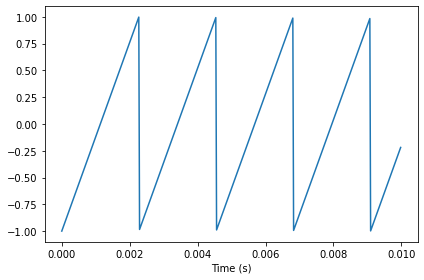

In [0]:
segment = wave.segment (duration=0.01)
segment.plot()
decorate(xlabel='Time (s)')

Pad the window so it's the same length as the signal, & plot it.

In [0]:
def zero_pad(array, n):
    """Extends an array with zeros.

    array: NumPy array
    n: length of result

    returns: new NumPy array
    """
    res = np.zeros(n)
    res[:len(array)] = array
    return res

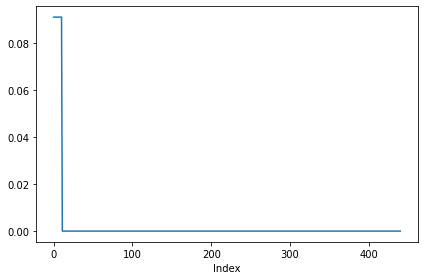

In [0]:
N = len(segment)
padded = zero_pad(window, N)
plt.plot(padded)
decorate(xlabel='Index')



Apply the window to the signal (with lag=0).


In [0]:
prod = padded * segment.ys
np.sum(prod)

-0.9001814882032255

Compute a convolution by rolling the window to the right.

In [0]:
smoothed = np.zeros (N)     #space to store result (signal after convolution)
rolled = padded.copy()      #copy of the window (shown above)
#Each time I apply the role operation, it is going to shift the window as one sound to the right
for i in range(N):
  smoothed[i] = sum(rolled * segment.ys)
  rolled = np.roll(rolled, 1)

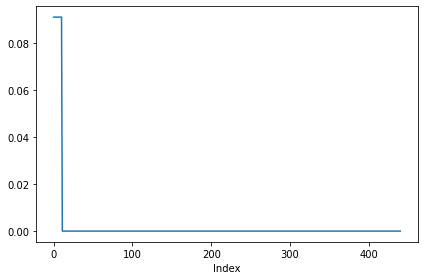

In [0]:
plt.plot(rolled)
decorate(xlabel='Index')

Plot the result of the convolution and the original.

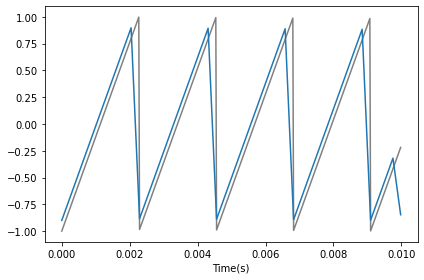

In [0]:
from thinkdsp import Wave

segment.plot(color='gray')
smooth = Wave(smoothed, framerate=wave.framerate)
smooth.plot()
decorate(xlabel='Time(s)')

Compute the same convolution using numpy.convolve.

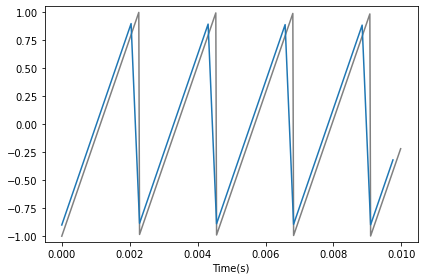

In [0]:
segment.plot(color='gray')
ys = np.convolve(segment.ys, window, mode='valid')
smooth2 = Wave(ys, framerate=wave.framerate)
smooth2.plot()
decorate(xlabel='Time(s)', ylim=[-1.05, 1.05])

#Effect of Moving Average in Frequency Domain
Visually, 

1) Applying Moving Average to the ***Signal***, it gets smoother.

2) Applying Moving Average to the ***Spectrum***, it gets?

***Conjecture***
Smoothing the Signal in the time domain corresponds to the low pass filter in the frequency domain. But what kind of filter is it??


![alt text](https://drive.google.com/uc?id=1kS6R-yMlj-gwr1hDS_3RjII2VWOb7p0S)

'*' is for Convolution

'x' is for multiplication

(Validating the Convolution Theorem)

Compute the smoothed wave using np.convolve, which is much faster than my version above.

In [0]:
convolved = np.convolve(wave.ys, window, mode='same')
smooth = Wave(convolved, framerate=wave.framerate)
smooth.make_audio()

Plot spectrums of the original and smoothed waves:

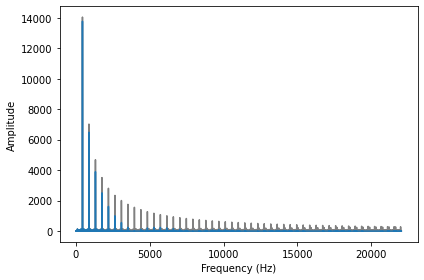

In [0]:
spectrum = wave.make_spectrum() #Input Spectrum
spectrum.plot(color='gray')

spectrum2 = smooth.make_spectrum() #Output (Post Convolution)
spectrum2.plot()

decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

For each harmonic, compute the ratio of the amplitudes before and after smoothing.


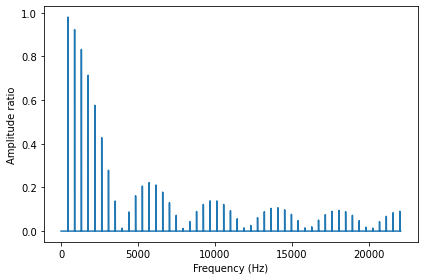

In [0]:
amps = spectrum.amps
amps2 = spectrum2.amps
ratio = amps2 / amps    
ratio[amps<280] = 0
#computed the Ratio of Output to the input amplitude
plt.plot(ratio)
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude ratio')

It is acting like a low pass filter. The filter below 5000 Hz is getting passed & above it is getting attenuated. But the high frequencies are still existing.

Q. Why divide?

A. It's more like a mathematical equation; 'a' multiplied by something gives 'b' so b/a must give that something.

#What happens if we plot the Fourier Transform of the Window too? 
(as a mathematical coloraly for the two equations in the above picture)

Plot the ratios again, but also plot the FFT of the window.


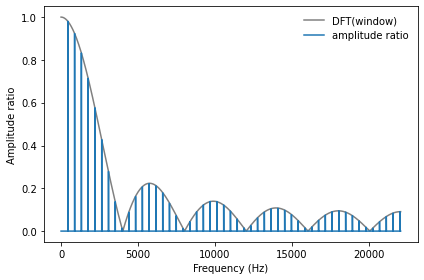

In [0]:
padded =  zero_pad(window, len(wave))
dft_window = np.fft.rfft(padded)

plt.plot(np.abs(dft_window), color='gray', label='DFT(window)')
plt.plot(ratio, label='amplitude ratio')

decorate(xlabel='Frequency (Hz)', ylabel='Amplitude ratio')

This Experimentally tells us about the filter.

![alt text](https://drive.google.com/uc?id=1TLFwOLJnDJff-7RdQWrYOTsGP-0y0VPR)

This fundamentally defines convolution: 

Convolution with a window in the time domain corresponds to multiplication by a filter in the frequency domain. And the filter is nothing but the DFT of the Window.

![alt text](https://drive.google.com/uc?id=1l2FbHF4ag1RpIyakKYlgvueexeVmT19v)

This is the best explaination to convolution. It says, you go either way (green or yellow arrow), the result is same.

Q. Why does it even matter which arrow we take?

A. While yellow one, the time domain (without convolution) takes $N^2 log(N)$ ; the red one, the frequency domain (with convolution) takes $NlogN$ complexity.

#About the Boxcar Window 
The boxcar window corresponds to a low-pass filter. But not a good one. Because it looks like a square wave which has slowly decaying harmonics.

(Remember? The DFT of the square wave looked similar - slowly decaying harmonics)

#Observation
If your window is not sharp in the time domain, your filter will be sharper in the frequency domain.

Therefore, one way to make these harmonics vanish is to smoothen the window.

#Gaussian Window
A smoother window (in time domain) has a sharper cutoff (in frequency domain).

Let's compare the boxcar & Gaussian windows.

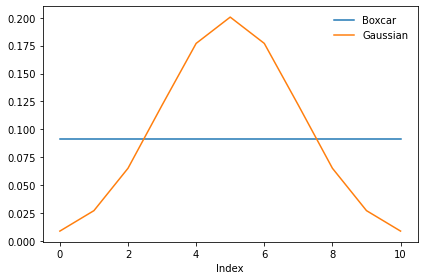

In [0]:
#Create Boxcar Window
boxcar = np.ones(11)
boxcar /= sum (boxcar)

#Create Gaussian Window
import scipy.signal

gaussian = scipy.signal.gaussian (M=11, std = 2)
gaussian /= sum(gaussian)

#Plot the two
plt.plot(boxcar, label = 'Boxcar')
plt.plot(gaussian, label = 'Gaussian')
decorate (xlabel='Index')

Convolve the square wave with the Gaussian window.

In [0]:
ys = np.convolve(wave.ys, gaussian, mode='same')
smooth = Wave(ys, framerate=wave.framerate)
spectrum2 = smooth.make_spectrum()

Compute the ratio of the amplitudes.

In [0]:
amps = spectrum.amps
amps2 = spectrum2.amps
ratio = amps2 / amps    
ratio[amps<560] = 0

Compute the FFT of the window.

In [0]:
padded =  zero_pad(gaussian, len(wave))
dft_gaussian = np.fft.rfft(padded)

Plot the ratios & the FFT of the window.

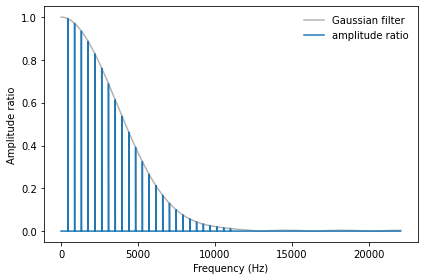

In [0]:
plt.plot(np.abs(dft_gaussian), color='0.7', label='Gaussian filter')
plt.plot(ratio, label='amplitude ratio')

decorate(xlabel='Frequency (Hz)', ylabel='Amplitude ratio')

#Interactive Gaussian Window

In [0]:
from thinkdsp import SquareSignal

def plot_filter(M=11, std=2):
    signal = SquareSignal(freq=440)
    wave = signal.make_wave(duration=1, framerate=44100)
    spectrum = wave.make_spectrum()

    gaussian = scipy.signal.gaussian(M=M, std=std)
    gaussian /= sum(gaussian)

    ys = np.convolve(wave.ys, gaussian, mode='same')
    smooth =  Wave(ys, framerate=wave.framerate)
    spectrum2 = smooth.make_spectrum()

    # plot the ratio of the original and smoothed spectrum
    amps = spectrum.amps
    amps2 = spectrum2.amps
    ratio = amps2 / amps    
    ratio[amps<560] = 0

    # plot the same ratio along with the FFT of the window
    padded =  zero_pad(gaussian, len(wave))
    dft_gaussian = np.fft.rfft(padded)

    plt.plot(np.abs(dft_gaussian), color='gray', label='Gaussian filter')
    plt.plot(ratio, label='amplitude ratio')

    decorate(xlabel='Frequency (Hz)', ylabel='Amplitude ratio')
    plt.show()

Try out different values of M and std.


In [0]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

slider = widgets.IntSlider(min=2, max=100, value=11)
slider2 = widgets.FloatSlider(min=0, max=20, value=2)
interact(plot_filter, M=slider, std=slider2);

interactive(children=(IntSlider(value=11, description='M', min=2), FloatSlider(value=2.0, description='std', m…

Here, 
* std = Standard deviation of the bell gaussian.
* M = Number of places we started the window. (we started with 11)

As the std gets wide, I am getting an approximation of the worse Guassian Curve that is an approximation to the Boxcar. If std is really wide, then it practically is the boxcar window. Hence more harmonics.

But if we keep the std high, & increase M, we get an approximation of nearly a good low pass filter with few harmonics.

#Summary of Gaussian Window
* Wider window means more smoothing which means a lower cutoff. 
* If std is too big or M is too small; 
      1) The Gausssian gets cut off,
      2) It looks more like a boxcar, and
      3) The high frequency bounces come back (the harmonics). 

#Convolution
In layman terms, Multiply -> Add -> Shift-> Repeat

1)   Multiply the signal by the window elementwise.

2) Add up the product.

3) Record the result.

4) Shift the window one element to the right.

5) Repeat
